# Inverse Transform Sampling with Chebyshev Polynomials

I'm working on coding up an inverse transform sampler that uses Chebyshev approximations of the CDF to speed things up. This follows the work of [Olver & Townsend, 2013](https://arxiv.org/pdf/1307.1223.pdf).

We'll see that this approach is not as fast as we would hope. The key here is that the function `chebeval` is highly vectorized, and so is much faster than a numerically integrated CDF **when evaluated at many inputs simultaneously.** However, the root-finding functions in scipy do one evaluation at each iteration, so they do not take advantage of this vectorized structure. When doing single evaluations of the functions, `chebeval` is about the same speed as `quad`.

The MATLAB code for this function (called `sample` in the paper) does not appear to be in the library [`chebfun`](http://www.chebfun.org/), so I cannot see how they attained the speeds reported in the paper. Presumably we need to implement a root-finding algorithm that takes advantage of the vectorized nature of `chebeval`, but I am not sure which would be best at this point.

We'll follow the example from the original notebook `example.ipynb`, and use it to test timing and accuracy of this approach against the "naive" approach, in which the CDF is constructed via numerical quadrature.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def pdf(x):
    """A unit normal density, NOT normalized"""
    return np.exp(-x**2/2)

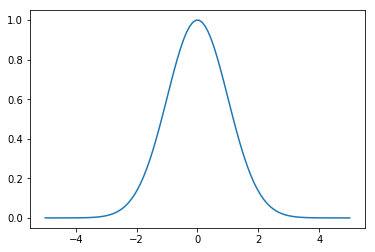

In [3]:
x = np.linspace(-5,5,100)
plt.plot(x,pdf(x));

So we've got ourselves a PDF, albeit without a normalization factor. Now let's use `sample` to draw samples from this distribution. **In this case we need to use upper and lower bounds so that our Chebyshev approach can be compared.**

In [4]:
import sys; sys.path.append('/Users/peterwills/google-drive/python/my_packages/itsample/')
from itsample import sample

In [5]:
%%timeit
samples = sample(pdf,1,lower_bd=-10, upper_bd=10)

1.96 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%%timeit
samples = sample(pdf,1,lower_bd=-10, upper_bd=10,chebyshev=True)

2.65 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%time
samples = sample(pdf,5000,lower_bd=-10, upper_bd=10)

CPU times: user 7.95 s, sys: 106 ms, total: 8.05 s
Wall time: 8.7 s


In [8]:
%%time
samples = sample(pdf,5000,lower_bd=-10, upper_bd=10,chebyshev=True)

CPU times: user 4.11 s, sys: 40.3 ms, total: 4.15 s
Wall time: 4.18 s


Gettong a single sample takes the same amount of time, which is disappointing. Getting many samples reduces the time somewhat, but we were hoping for better than what we see here. Note that in the original paper, the author claims to get **10,000 samples in <1 second.*** So we're about a factor of 15 off from that.

Let's make sure that we're getting accurate results.

In [9]:
from itsample import normalize
pdf_norm = normalize(pdf, vectorize=True)

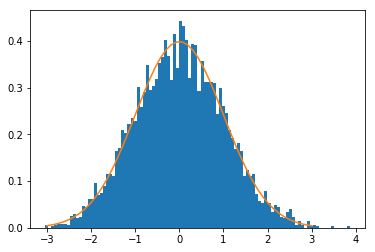

In [10]:
plt.hist(samples,bins=100,density=True);
x = np.linspace(-3,3)
plt.plot(x,pdf_norm(x))

# Line Profiling

In [15]:
%load_ext line_profiler

In [16]:
%lprun -f sample sample(pdf,5000,lower_bd=lower_bd,upper_bd=upper_bd, guess=guess)

### How long does it take to do function calls for each type of CDF?

In [17]:
from itsample import chebcdf, get_cdf

In [18]:
cdf = get_cdf(pdf,lower_bd,upper_bd)
cdf_cheb = chebcdf(pdf,lower_bd,upper_bd)

/Users/peterwills/google-drive/python/my_packages/itsample/itsample.py:128: RankWarning: The fit may be poorly conditioned
  coeffs = chebfit(x,y,n-1)


In [19]:
%%timeit
cdf(x[0:1])

58.9 µs ± 6.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
%%timeit
cdf_cheb(x[0:1])

66.5 µs ± 694 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
x = np.linspace(lower_bd, upper_bd, 100)

In [22]:
%%timeit
cdf(x)

8.1 ms ± 912 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
cdf_cheb(x)

92.9 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So evaluation of the chebyshev CDF is much faster if everything is properly vectorized, but is comparable if evaluating on a single scalar. Why doesn't this translate to better performance in `root`?

In [24]:
from scipy.optimize import root

In [25]:
seed = 0.5
cdf_shifted = lambda x: cdf(x)-seed
chebcdf_shifted = lambda x: cdf_cheb(x)-seed

In [26]:
%lprun -f root root(cdf_shifted,1)

Hrm, well that's not very illuminating. Just buries it deeper in some C code that scipy calls.

Anyways, this is mysterious to me. It seems intuitive that a single call to `chebeval` should be much faster than a single call to `quad`, which is what the original function does. I guess what it's doing in there is a big matrix multiplication, so it makes sense that it's just about as fast for 100 points as for 1. What we want is a root-finder that takes advantage of this, although I'm somewhat lost on how to do that. Perhaps evaluate on some grid, do bisection, and then evaluate on a smaller grid if need be? Sounds slow though, we'd be wasting a lot of computational power.